In [76]:
import cv2
import sqlite3
from matplotlib import pyplot as plt
import numpy as np

from visualize_model import Model
from database import blob_to_array, pair_id_to_image_ids

import utils
from utils import *

# 1. 3D mesh reconstruction from a set of images from the Gerrard Hall dataset.
Install Colmap and run the automatic reconstruction on the Gerrard Hall dataset

1) We downloaded the `gerrard-hall` dataset from https://colmap.github.io/datasets.html and stored it on path `lab4/gerrard-hall`.

2) We installed Colmap on UNIX really easily with any package manager of choice:

```bash
$ brew install colmap
$ colmap -h # to verify that works
```

3) Then we ran the `automatic_reconstructor` pipeline (as seen in their docs [here](https://github.com/colmap/colmap.github.io/blob/master/_sources/cli.rst.txt)) via CLI.

```bash
$ cd lab4/
$ colmap automatic_reconstructor \
    --workspace_path . \
    --image_path ./gerrard-hall/images
```

The reconstruction is stored under the `lab4/database.db` path.

\* Note that if we want to try different parameters we will have to run the reconstruction in different steps (reference [here](https://github.com/colmap/colmap.github.io/blob/master/_sources/cli.rst.txt))


Because files are in `.bin` format, we have to decode them to txt so that we can read them easily.

```bash
colmap model_converter \
    --input_path ./sparse/0/ \
    --output_path ./sparse/0/ \
    --output_type TXT
```

# 2. Analyze reconstructions using python
## 2.1. Run the notebook, using the Gerrard Hall reconstruction (0.5)
#### <span style='color:Green'> - Add the path to your reconstruction. Answer the questions at the end  </span>

In [3]:
# Add your path
reconstruction_path = "./sparse/0"
database_path = "./database.db"

#### Load an existing reconstruction and print its contents

In [4]:
model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

In [5]:
images = model.images
cameras = model.cameras
points3D = model.points3D

In [6]:
"""
from COLMAP docs: https://colmap.github.io/format.html 
The unique identifiers of cameras (CAMERA_ID), images (IMAGE_ID), and 3D points (POINT3D_ID) 
are unordered and are most likely not contiguous. 
"""

idx_images = next(iter(images))
idx_camera = next(iter(cameras))
idx_point3d = next(iter(points3D))

print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[idx_images])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[idx_camera])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[idx_point3d])

Loaded 98 images. This is the information available for one of them:
Image(id=1, qvec=array([-0.13316643,  0.01938725,  0.97132254, -0.19601879]), tvec=array([0.94717796, 1.08745837, 4.4189751 ]), camera_id=1, name='IMG_2331.JPG', xys=array([[1729.12634277, 1121.50134277],
       [ 874.54071045, 2874.25634766],
       [4424.20898438, 2655.8605957 ],
       ...,
       [5564.17236328,  256.39727783],
       [1752.71594238,  257.99530029],
       [ 823.69580078,  260.04330444]]), point3D_ids=array([-1, -1, -1, ..., -1, -1, -1]))

Loaded 1 cameras. This is the information available for one of them:
Camera(id=1, model='SIMPLE_RADIAL', width=5616, height=3744, params=array([ 3.82402417e+03,  2.80800000e+03,  1.87200000e+03, -6.97168319e-02]))

Loaded 71273 3D points. This is the information available for one of them:
Point3D(id=96251, xyz=array([ 2.28315334, -0.64964237, -1.2782611 ]), rgb=array([67, 67, 68]), error=array(2.55957303), image_ids=array([71, 72, 83, 69, 76, 73]), point2D_idxs=

#### Load the database

In [7]:
db = sqlite3.connect(database_path)

In [8]:
keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

In [9]:
print(f"Loaded keypoints from {len(keypoints)} images. These are the {len(keypoints[1])} keypoints for one of them:")
print(keypoints[1])

Loaded keypoints from 100 images. These are the 32652 keypoints for one of them:
[[ 1.7291263e+03  1.1215013e+03]
 [ 3.9597284e+02  0.0000000e+00]
 [ 2.4773894e+02  6.4793530e+02]
 ...
 [ 8.2369580e+02  2.6004330e+02]
 [ 4.0847859e+00 -1.0391687e-15]
 [ 4.4129825e-01  5.0973716e+00]]


In [10]:
matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")

Loaded 1879 matches. 3071/4950 matches contained no data


In [11]:
print("These are the matches between two images:")
print(matches[1,2])

These are the matches between two images:
[[    0     0]
 [    1     2]
 [    3     6]
 ...
 [10506 10705]
 [ 9586 10799]
 [ 9568 10852]]


#### Visualize the point cloud and cameras

In [12]:
model.create_window()
model.add_points()
model.add_cameras(scale=0.25)
model.show()

#### <span style='color:Green'>  How many keypoints there are in total? </span> 

In [13]:
# we check what tables are in the db
tables = db.execute("SELECT name FROM sqlite_master WHERE type='table';")

tables = tables.fetchall()
for i, table in enumerate(tables):
    print(f"Table {i+1}: {table[0]}")

Table 1: cameras
Table 2: sqlite_sequence
Table 3: images
Table 4: keypoints
Table 5: descriptors
Table 6: matches
Table 7: two_view_geometries


In [14]:
# decoded from binary with blob_to_array
keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

len(keypoints[1]) # first image has 32652

count = 0
for i, data in keypoints.items():
    count += len(data)

print(f"Number of total keypoints: {count}")

Number of total keypoints: 3114540


#### <span style='color:Green'>  How many 3D points originated from a keypoint in the first image? </span>


In [15]:
keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))


# get first image_id and corresponding kps
idx_image_1 = next(iter(images))
kps_image_1 = keypoints[idx_image_1]
print(f"Keypoints in Image {idx_image_1}: {kps_image_1.shape[0]}")

# select first keypoint
idx_keypoint_1 = 8971
kp = kps_image_1[idx_keypoint_1]

# TODO
kps = set()
for p3d_id, p3d in points3D.items():
    if (idx_image_1 in p3d.image_ids) and idx_keypoint_1 in p3d.point2D_idxs:
        kps.add(p3d_id)

print(f"From Keypoint {idx_keypoint_1} in Image {idx_image_1} there were {len(kps)} 3d Points associated")

Keypoints in Image 1: 32652
From Keypoint 8971 in Image 1 there were 7 3d Points associated


In [16]:
kps_image_1

array([[ 1.7291263e+03,  1.1215013e+03],
       [ 3.9597284e+02,  0.0000000e+00],
       [ 2.4773894e+02,  6.4793530e+02],
       ...,
       [ 8.2369580e+02,  2.6004330e+02],
       [ 4.0847859e+00, -1.0391687e-15],
       [ 4.4129825e-01,  5.0973716e+00]], dtype=float32)

## 2.2 Plot the 3D points coloured according to the number of images and error. (0.5)

#### <span style='color:Green'> - Plot the 3D points coloured according to the **number of images** from which it originated. </span> Can you extract any conclusions from the visualization? 

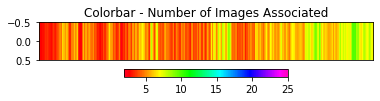

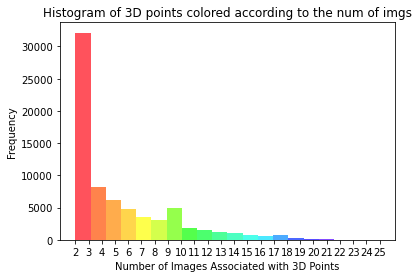

In [19]:
### TO DO 2.2

import open3d as o3d

num_images_associated = np.array([len(p3d.image_ids) for p3d in points3D.values()])

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(np.array([p3d.xyz for p3d in points3D.values()]))

n_imgs_norm = (num_images_associated-np.min(num_images_associated))/(np.max(num_images_associated)-np.min(num_images_associated))
colors = plt.cm.gist_rainbow(n_imgs_norm)

point_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([point_cloud])

# Create a colorbar image
fig, ax = plt.subplots(figsize=(6, 1))
cax = ax.imshow([num_images_associated], cmap=plt.cm.gist_rainbow, aspect='auto')
ax.set_title('Colorbar - Number of Images Associated')
ax.set_xticks([])
fig.colorbar(cax, orientation='horizontal', ax=ax)
plt.show()

sorted_indices = np.argsort(num_images_associated)
sorted_num_images = num_images_associated[sorted_indices]
sorted_colors = colors[sorted_indices]

bins = np.histogram_bin_edges(sorted_num_images, bins=20)

bin_colors = []
for i in range(len(bins) - 1):
    in_bin = (sorted_num_images >= bins[i]) & (sorted_num_images < bins[i + 1])
    avg_color = np.mean(sorted_colors[in_bin], axis=0)
    bin_colors.append(avg_color)

n, bins, patches = plt.hist(sorted_num_images, bins=bins, alpha=0.7)

for patch, color in zip(patches, bin_colors):
    patch.set_facecolor(color)

plt.xlabel('Number of Images Associated with 3D Points')
plt.ylabel('Frequency')
plt.title('Histogram of 3D points colored according to the num of imgs')
plt.xticks(sorted(np.unique(num_images_associated)))

plt.show()

#### <span style='color:Green'> - Plot the 3D points coloured according to the **error**. </span> - What is this parameter? Can you extract any conclusions from the visualization?

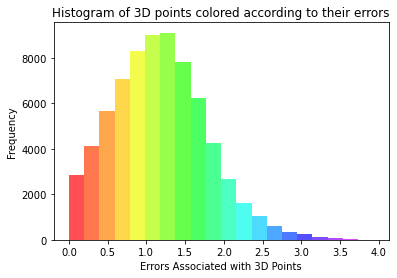

In [20]:
### TO DO 2.2

import open3d as o3d

# extract the errors for each 3D point from the 'points3D' dictionary
errors = np.array([p3d.error for p3d in points3D.values()])

errors_norm = (errors-np.min(errors))/(np.max(errors)-np.min(errors))
colors = plt.cm.gist_rainbow(errors_norm)

# create an Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(np.array([p3d.xyz for p3d in points3D.values()]))
point_cloud.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([point_cloud])

sorted_indices = np.argsort(errors)
sorted_errors = errors[sorted_indices]
sorted_colors = colors[sorted_indices]

bins = np.histogram_bin_edges(sorted_errors, bins=20)

bin_colors = []
for i in range(len(bins) - 1):
    in_bin = (sorted_errors >= bins[i]) & (sorted_errors < bins[i + 1])
    avg_color = np.mean(sorted_colors[in_bin], axis=0)
    bin_colors.append(avg_color)

n, bins, patches = plt.hist(sorted_errors, bins=bins, alpha=0.7)

for patch, color in zip(patches, bin_colors):
    patch.set_facecolor(color)

plt.xlabel('Errors Associated with 3D Points')
plt.ylabel('Frequency')
plt.title('Histogram of 3D points colored according to their errors')
#plt.xticks(sorted(np.unique(errors)))

plt.show()


## 2.3 Plot the 3D points that correspond to a keypoint in the first image. Also plot the image with the keypoints (1.0)


In [21]:
import open3d as o3d

# get first image_id and corresponding kps
idx_image_1 = next(iter(images))
kps_image_1 = keypoints[idx_image_1]
print(f"Keypoints in Image {idx_image_1}: {kps_image_1.shape[0]}")

# select a keypoint
idx_keypoint_1 = 8971
kp = kps_image_1[idx_keypoint_1]

kps = []
for p3d_id, p3d in points3D.items():
    if (idx_image_1 in p3d.image_ids) and idx_keypoint_1 in p3d.point2D_idxs:
        kps.append(p3d)

point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(np.array([kp.xyz for kp in kps]))
o3d.visualization.draw_geometries([point_cloud])

Keypoints in Image 1: 32652


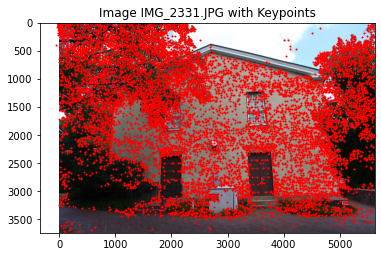

In [22]:
import cv2
import matplotlib.pyplot as plt

image_path = f'gerrard-hall/images/{images[idx_image_1].name}'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

plt.scatter(*zip(*kps_image_1), color='red', s=1)  # Scatter plot for keypoints
plt.title(f'Image {images[idx_image_1].name} with Keypoints')
plt.show()

## 2.4 Create a visualization for the number of matches between all images. (1.0)
For example: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [23]:
matches_count = np.zeros((100, 100))
for imgs, match_list in matches.items():
    num_matches = len(match_list)
    id1, id2 = imgs
    
    rid1 = int(id1)-1
    rid2 = id2-1
    
    print(f'real ids: {[rid1, rid2]} and the number of matches is: {num_matches}')
    
    matches_count[rid1, rid2] = num_matches
    matches_count[rid2, rid1] = num_matches
    
print(matches_count)

real ids: [0, 1] and the number of matches is: 2715
real ids: [0, 2] and the number of matches is: 1689
real ids: [0, 3] and the number of matches is: 1154
real ids: [0, 4] and the number of matches is: 748
real ids: [0, 5] and the number of matches is: 529
real ids: [0, 6] and the number of matches is: 862
real ids: [0, 7] and the number of matches is: 1086
real ids: [0, 8] and the number of matches is: 1169
real ids: [0, 9] and the number of matches is: 1047
real ids: [0, 10] and the number of matches is: 899
real ids: [0, 11] and the number of matches is: 673
real ids: [0, 12] and the number of matches is: 486
real ids: [0, 13] and the number of matches is: 313
real ids: [0, 14] and the number of matches is: 202
real ids: [0, 15] and the number of matches is: 40
real ids: [0, 92] and the number of matches is: 61
real ids: [0, 93] and the number of matches is: 142
real ids: [0, 94] and the number of matches is: 298
real ids: [0, 95] and the number of matches is: 399
real ids: [0, 96]

C:\Users\ialak\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<AxesSubplot:>

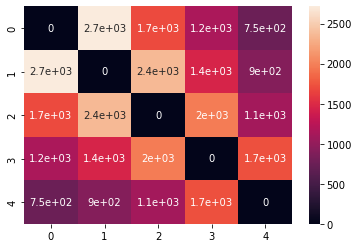

In [24]:
### TO DO 2.4
import seaborn as sns
sns.heatmap(matches_count[:5, :5], annot=True)

<AxesSubplot:>

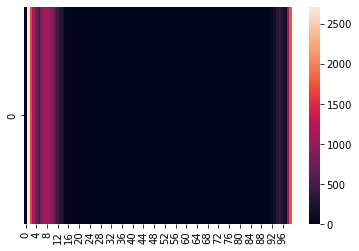

In [25]:
sns.heatmap(matches_count[:1, :100], annot=False)

## 2.5 Visualize the keypoints and matches between the two images used in lab 3 using Colmap, how it compares to the results from lab 3? (1.0)
#### <span style='color:Green'> You can use the GUI to get the keypoints and matches and then visualize it here, following the same style as in lab 3 to get comparable results. </span>

In [28]:
### TO DO 2.5

## 2.6 Triangulate and visualize the 3D points from the keypoints extracted using Colmap on the two images used in lab 3, how it compares to the results from lab 3? (1.0) 
#### <span style='color:Green'> - Use the triangulation from lab 3 to the get the 3D points and visualize them following the same style. </span>

In [93]:
# Add your path
reconstruction_path = "./task256/sparse/0"
database_path = "./task256/database.db"

In [94]:
model = Model()
model.read_model(reconstruction_path, ext='.bin') # Should also work with .txt

In [95]:
images = model.images
cameras = model.cameras
points3D = model.points3D

In [96]:
"""
from COLMAP docs: https://colmap.github.io/format.html 
The unique identifiers of cameras (CAMERA_ID), images (IMAGE_ID), and 3D points (POINT3D_ID) 
are unordered and are most likely not contiguous. 
"""

idx_images = next(iter(images))
idx_camera = next(iter(cameras))
idx_point3d = next(iter(points3D))

print(f"Loaded {len(images)} images. This is the information available for one of them:")
print(images[idx_images])
print(f"\nLoaded {len(cameras)} cameras. This is the information available for one of them:")
print(cameras[idx_camera])
print(f"\nLoaded {len(points3D)} 3D points. This is the information available for one of them:")
print(points3D[idx_point3d])

Loaded 2 images. This is the information available for one of them:
Image(id=1, qvec=array([1., 0., 0., 0.]), tvec=array([-4.28760249,  0.54953157,  2.5128629 ]), camera_id=2, name='0002_s.png', xys=array([[364.11279297, 383.38278198],
       [751.6295166 , 431.08297729],
       [503.05007935, 486.63323975],
       ...,
       [464.28674316, 215.22648621],
       [ 36.29299927, 213.98588562],
       [ 60.05096054, 415.66879272]]), point3D_ids=array([  -1,   -1,   -1, ..., 1901,   -1, 1902]))

Loaded 2 cameras. This is the information available for one of them:
Camera(id=1, model='SIMPLE_RADIAL', width=922, height=614, params=array([ 8.05193713e+02,  4.61000000e+02,  3.07000000e+02, -6.53670432e-02]))

Loaded 1900 3D points. This is the information available for one of them:
Point3D(id=1, xyz=array([26.73735397, -5.72354513, 54.06993684]), rgb=array([116, 137, 186]), error=array(0.96204972), image_ids=array([1, 2]), point2D_idxs=array([3, 3]))


In [97]:
#### Load the database

db = sqlite3.connect(database_path)

keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

print(f"Loaded keypoints from {len(keypoints)} images. These are the {len(keypoints[1])} keypoints for one of them:")
print(keypoints[1])

matches = dict()
count_no_data = 0
for pair_id, data in db.execute("SELECT pair_id, data FROM matches"):
    if data is None:
        count_no_data += 1
    else:
        matches[pair_id_to_image_ids(pair_id)] = blob_to_array(data, np.uint32, (-1, 2))
print(f"Loaded {len(matches)} matches. {count_no_data}/{len(matches)+count_no_data} matches contained no data")

print("These are the matches between two images:")
print(matches[1,2])

#### Visualize the point cloud and cameras

model.create_window()
model.add_points()
model.add_cameras(scale=0.25)
model.show()

#### <span style='color:Green'>  How many keypoints there are in total? </span> 

# we check what tables are in the db
tables = db.execute("SELECT name FROM sqlite_master WHERE type='table';")

tables = tables.fetchall()
for i, table in enumerate(tables):
    print(f"Table {i+1}: {table[0]}")

# decoded from binary with blob_to_array
keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))

len(keypoints[1]) # first image has 32652

count = 0
for i, data in keypoints.items():
    count += len(data)

print(f"Number of total keypoints: {count}")

#### <span style='color:Green'>  How many 3D points originated from a keypoint in the first image? </span>


keypoints = dict(
        (image_id, blob_to_array(data, np.float32, (-1, 2)))
        for image_id, data in db.execute(
            "SELECT image_id, data FROM keypoints"))


# get first image_id and corresponding kps
idx_image_1 = next(iter(images))
kps_image_1 = keypoints[idx_image_1]
print(f"Keypoints in Image {idx_image_1}: {kps_image_1.shape[0]}")

# select first keypoint
idx_keypoint_1 = 8971
kp = kps_image_1[idx_keypoint_1]

# TODO
kps = set()
for p3d_id, p3d in points3D.items():
    if (idx_image_1 in p3d.image_ids) and idx_keypoint_1 in p3d.point2D_idxs:
        kps.add(p3d_id)

print(f"From Keypoint {idx_keypoint_1} in Image {idx_image_1} there were {len(kps)} 3d Points associated")

kps_image_1

Loaded keypoints from 2 images. These are the 11511 keypoints for one of them:
[[ 3.6411279e+02  3.8338278e+02]
 [ 1.5602490e+02 -5.3290705e-15]
 [ 1.2845985e+01  5.4400043e+01]
 ...
 [ 6.0050961e+01  4.1566879e+02]
 [ 3.8201103e+00  2.4286129e-17]
 [ 1.3039660e-01  8.6759084e-01]]
Loaded 1 matches. 0/1 matches contained no data
These are the matches between two images:
[[   1    0]
 [   3    3]
 [   4    6]
 ...
 [3831 2857]
 [3834 3364]
 [3836 3982]]
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
Table 1: cameras
Table 2: sqlite_sequence
Table 3: images
Table 4: keypoints
Table 5: descriptors
Table 6: matches
Table 7: two_view_geometries
Number of total keypoints: 24132
Keypoints in Image 1: 11511
From Keypoint 8971 in Image 1 there were 0 3d Points associated


array([[ 3.6411279e+02,  3.8338278e+02],
       [ 1.5602490e+02, -5.3290705e-15],
       [ 1.2845985e+01,  5.4400043e+01],
       ...,
       [ 6.0050961e+01,  4.1566879e+02],
       [ 3.8201103e+00,  2.4286129e-17],
       [ 1.3039660e-01,  8.6759084e-01]], dtype=float32)

In [98]:
matches

{(1.0,
  2): array([[   1,    0],
        [   3,    3],
        [   4,    6],
        ...,
        [3831, 2857],
        [3834, 3364],
        [3836, 3982]], dtype=uint32)}

In [99]:
keypoints

{1: array([[ 3.6411279e+02,  3.8338278e+02],
        [ 1.5602490e+02, -5.3290705e-15],
        [ 1.2845985e+01,  5.4400043e+01],
        ...,
        [ 6.0050961e+01,  4.1566879e+02],
        [ 3.8201103e+00,  2.4286129e-17],
        [ 1.3039660e-01,  8.6759084e-01]], dtype=float32),
 2: array([[7.00136597e+02, 4.64777313e+02],
        [2.73735474e+02, 9.32587341e-15],
        [9.56881523e-01, 6.73772812e+01],
        ...,
        [1.07367195e+02, 1.54333847e+02],
        [2.94431949e+00, 0.00000000e+00],
        [1.02903688e+00, 9.25787508e-01]], dtype=float32)}

In [100]:
kp1 = keypoints[1]
kp2 = keypoints[2]

In [101]:
value=matches[(1.0, 2)]

In [102]:
points1 = []
for index1 in value[:, 0]:
    x, y = kp1[index1]
    points1.append([x, y, 1])
    
points2 = []
for index2 in value[:, 0]:
    x, y = kp2[index2]
    points2.append([x, y, 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

In [103]:
from numpy import linalg as LA

def normalize_p(p):
    
    num_p = p.shape[1]
    
    p[:, :] /= p[2, :]
    
    # centroid
    centroid = []
    centroid_x = np.mean(p[0, :]) # x
    centroid_y = np.mean(p[1, :]) # y
    
    # mean distance to origin
    origin_x = np.empty(num_p)
    origin_x = p[0, :] - centroid_x
    
    origin_y = np.empty(num_p)
    origin_y = p[1, :] - centroid_y
    d = np.sqrt(origin_x[:]**2 + origin_y[:]**2)
    d_mean = np.mean(d)
    
    # scaling
    s = np.sqrt(2)/d_mean
    
    # translation
    t = [-s*centroid_x, -s*centroid_y]
    H = np.array([[s, 0, t[0]],
                  [0, s, t[1]],
                  [0, 0,   1]])
    
    p_norm = H @ p
    
    return p_norm, H

def fundamental_matrix(points1, points2, check_n=False):
    
    # point normalization
    #p1n = points1[:, :]/points1[2, :]
    #p2n = points2[:, :]/points2[2, :]
    p1n, H1 = normalize_p(points1)
    p2n, H2 = normalize_p(points2)
    
    if check_n:
        # check of normalizations
        print('The normalized centroid of points1 is located at:')
        print([f'{np.mean(p1n[0, :]):.5f}', f'{np.mean(p1n[1, :]):.5f}'])

        print('\nThe mean squared distance between normalized points1 and origin is:')
        print(f'{(np.mean(np.sqrt(p1n[0, :]**2 + p1n[1, :]**2))**2):.5f} \n\n')

        print('The normalized centroid of points2 is located at:')
        print([f'{np.mean(p2n[0, :]):.5f}', f'{np.mean(p2n[1, :]):.5f}'])

        print('\nThe mean squared distance between normalized points2 and origin is:')
        print(f'{(np.mean(np.sqrt(p2n[0, :]**2 + p2n[1, :]**2))**2):.5f} \n\n')
    
    _, n_points = points1.shape
    
    # W
    W = np.ones((n_points, 9)) # W is of size nx9
    W[:, 0] = p1n[0, :]*p2n[0, :]
    W[:, 1] = p1n[1, :]*p2n[0, :]
    W[:, 2] =           p2n[0, :]
    W[:, 3] = p1n[0, :]*p2n[1, :]
    W[:, 4] = p1n[1, :]*p2n[1, :]
    W[:, 5] =           p2n[1, :]
    W[:, 6] = p1n[0, :]
    W[:, 7] = p1n[1, :]
    #W[:, 8] = 1
    
    U, D, Vt = LA.svd(W)
    
    F_r3 = np.reshape(Vt[-1, :], (3, 3))
    
    # force F to have rank 2
    U_F, D_F, Vt_F = LA.svd(F_r3)
    
    D_new = [[D_F[0],      0, 0],
             [0     , D_F[1], 0],
             [0     ,      0, 0]]
    
    F_n = U_F @ D_new @ Vt_F
    
    # denormalize F
    F = H2.T @ F_n @ H1
    
    return F

In [104]:
F = fundamental_matrix(points1, points2)

In [105]:
F

array([[ 1.71632069e-06,  7.05594237e-06, -3.38281095e-03],
       [ 2.77817951e-06, -1.88592635e-05,  4.84539424e-03],
       [-1.78577542e-03,  3.03135562e-03, -1.58593558e-02]])

In [106]:
# Camera calibration matrix
K = np.array([[2362.12, 0, 1520.69], [0, 2366.12, 1006.81], [0, 0, 1]])
scale = 0.3;
H = np.array([[scale, 0, 0], [ 0, scale, 0], [0, 0, 1]])
K = H @ K;

I = np.eye(3,4)
P1 = K @ I

In [107]:
def essential_from_fundamental(K, F):
    return K.T @ F @ K

E = essential_from_fundamental(K, F)

In [108]:
# camera projection matrix for the first camera

# First camera is reference so external parameters matrix are equal to identity
I = np.eye(3,4)
P1 = K @ I

# # four possible matrices for the second camera
Pc2 = [None, None, None, None];

# helper matrices W and Z
W = np.array([[0, -1,  0],
              [1,  0,  0],
              [0,  0,  1]])
Z = -W

# SVD of E to obtain U
U, D, Vt = np.linalg.svd(E)

# two solutions for translation located in the end column of U (or end row of U^T)
t1 = +U[:, -1]
t2 = -U[:, -1]

# another two solutions for rotation are made with W and its transpose
r1 = U @ W @ Vt
r2 = U @ W.T @ Vt

# suggestion from the above markdown cell
if np.linalg.det(r1) < 0:
    r1 = -r1
if np.linalg.det(r2) < 0:
    r2 = -r2

# system of equations
Pc2[0] = np.hstack((r1, t1[:, np.newaxis]))
Pc2[1] = np.hstack((r1, t2[:, np.newaxis]))
Pc2[2] = np.hstack((r2, t1[:, np.newaxis]))
Pc2[3] = np.hstack((r2, t2[:, np.newaxis]))

# convert from camera coords (distances) to pixels through the intrinsic
#P1 = K @ P1
Pc2[0] = K @ Pc2[0]
Pc2[1] = K @ Pc2[1]
Pc2[2] = K @ Pc2[2]
Pc2[3] = K @ Pc2[3]

In [109]:
img1c = cv2.imread('Data_W3/0001_s.png')
img2c = cv2.imread('Data_W3/0002_s.png')
img1c = cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB) 
img2c = cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB) 

img1 = cv2.cvtColor(img1c, cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(img2c, cv2.COLOR_RGB2GRAY)


h, w = img1.shape

(-1.5, 1.5)

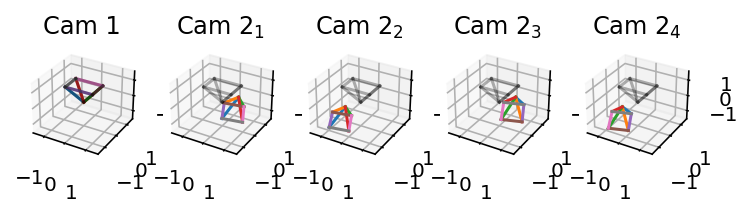

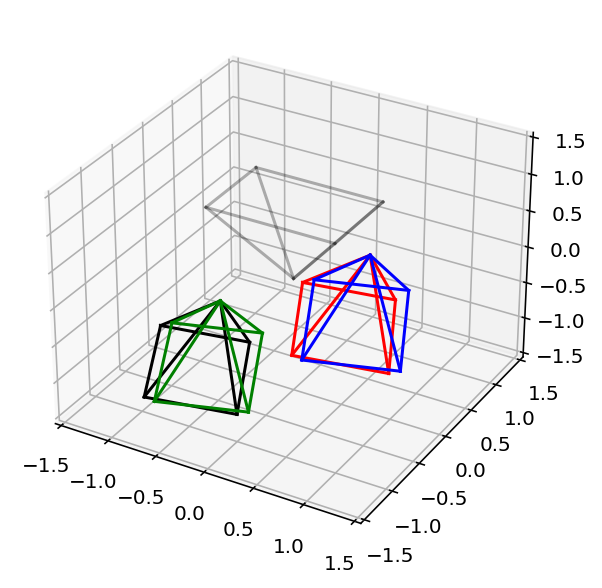

In [110]:
%config InlineBackend.figure_format='retina'

# plot the first camera and the four possible solutions for the second figure:
fig = plt.figure()
axs = [fig.add_subplot(1,5,i+1, projection='3d') for i in range(5)]
titles = ["Cam 1"] + [r"Cam $2_{%s}$" % int(i+1) for i in range(len(Pc2)) ]

low_lim, up_lim = -1.5, 1.5
for ax, title, P in zip(axs, titles, [P1] + Pc2):
    utils.plot_camera(P,w,h, 1, ax=ax)
    utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
    ax.set_title(title)
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)
    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
for P, color in zip(Pc2, ['r','k','b','g']):
    utils.plot_camera(P,w,h, 1, ax=ax, color=color)
utils.plot_camera(P1,w,h, 1, ax=ax, alpha=0.3, color="k") # Show Cam1 for reference
ax.set_xlim(low_lim, up_lim)
ax.set_ylim(low_lim, up_lim)
ax.set_zlim(low_lim, up_lim)

In [111]:
# Write here the method for DLT triangulation
def triangulate(x1, x2, P1, P2, imsize) -> np.ndarray:
    assert P1.shape == (3,4) == P2.shape
    assert x1.shape == x2.shape and x1.shape[0] == 3
    
    # only one point
    if x1.ndim == 1:
        x1 = np.array([x1]).T
        x2 = np.array([x2]).T
    
    n_points = x1.shape[1]
    
    #x1=projective2img(x1)
    #x2=projective2img(x2)
    
    x1 = x1/x1[2,:]
    x2 = x2/x2[2,:]
    
    #Image shape
    nx=imsize[0]
    ny=imsize[1]
    
    #Normalization
    H = [[2/nx,0,-1],
         [0,2/ny,-1],
         [0,0,1]]
    
    x1_norm = H @ x1
    x2_norm = H @ x2
    P1_norm = H @ P1
    P2_norm = H @ P2
    
    X = np.empty(shape=(4,n_points))
    
    #Matrix A
    for i in range(n_points):
        
        A = np.array([x1_norm[0,i]*P1_norm[2,:]-P1_norm[0,:],
                      x1_norm[1,i]*P1_norm[2,:]-P1_norm[1,:],
                      x2_norm[0,i]*P2_norm[2,:]-P2_norm[0,:],
                      x2_norm[1,i]*P2_norm[2,:]-P2_norm[1,:]])
        
        U, S, Vh = LA.svd(A)
    
        X[:,i] = Vh[-1,:]
        
    return X

1406
0
368
0
[[-3.94076688e+02  5.85568658e+02 -4.60546109e+02  4.84760104e+02]
 [ 5.67715647e+02  2.62028955e+02 -4.51815108e+02  3.41700053e+02]
 [-1.90379646e-01 -1.15760760e-01 -9.74861547e-01  9.97498263e-01]]


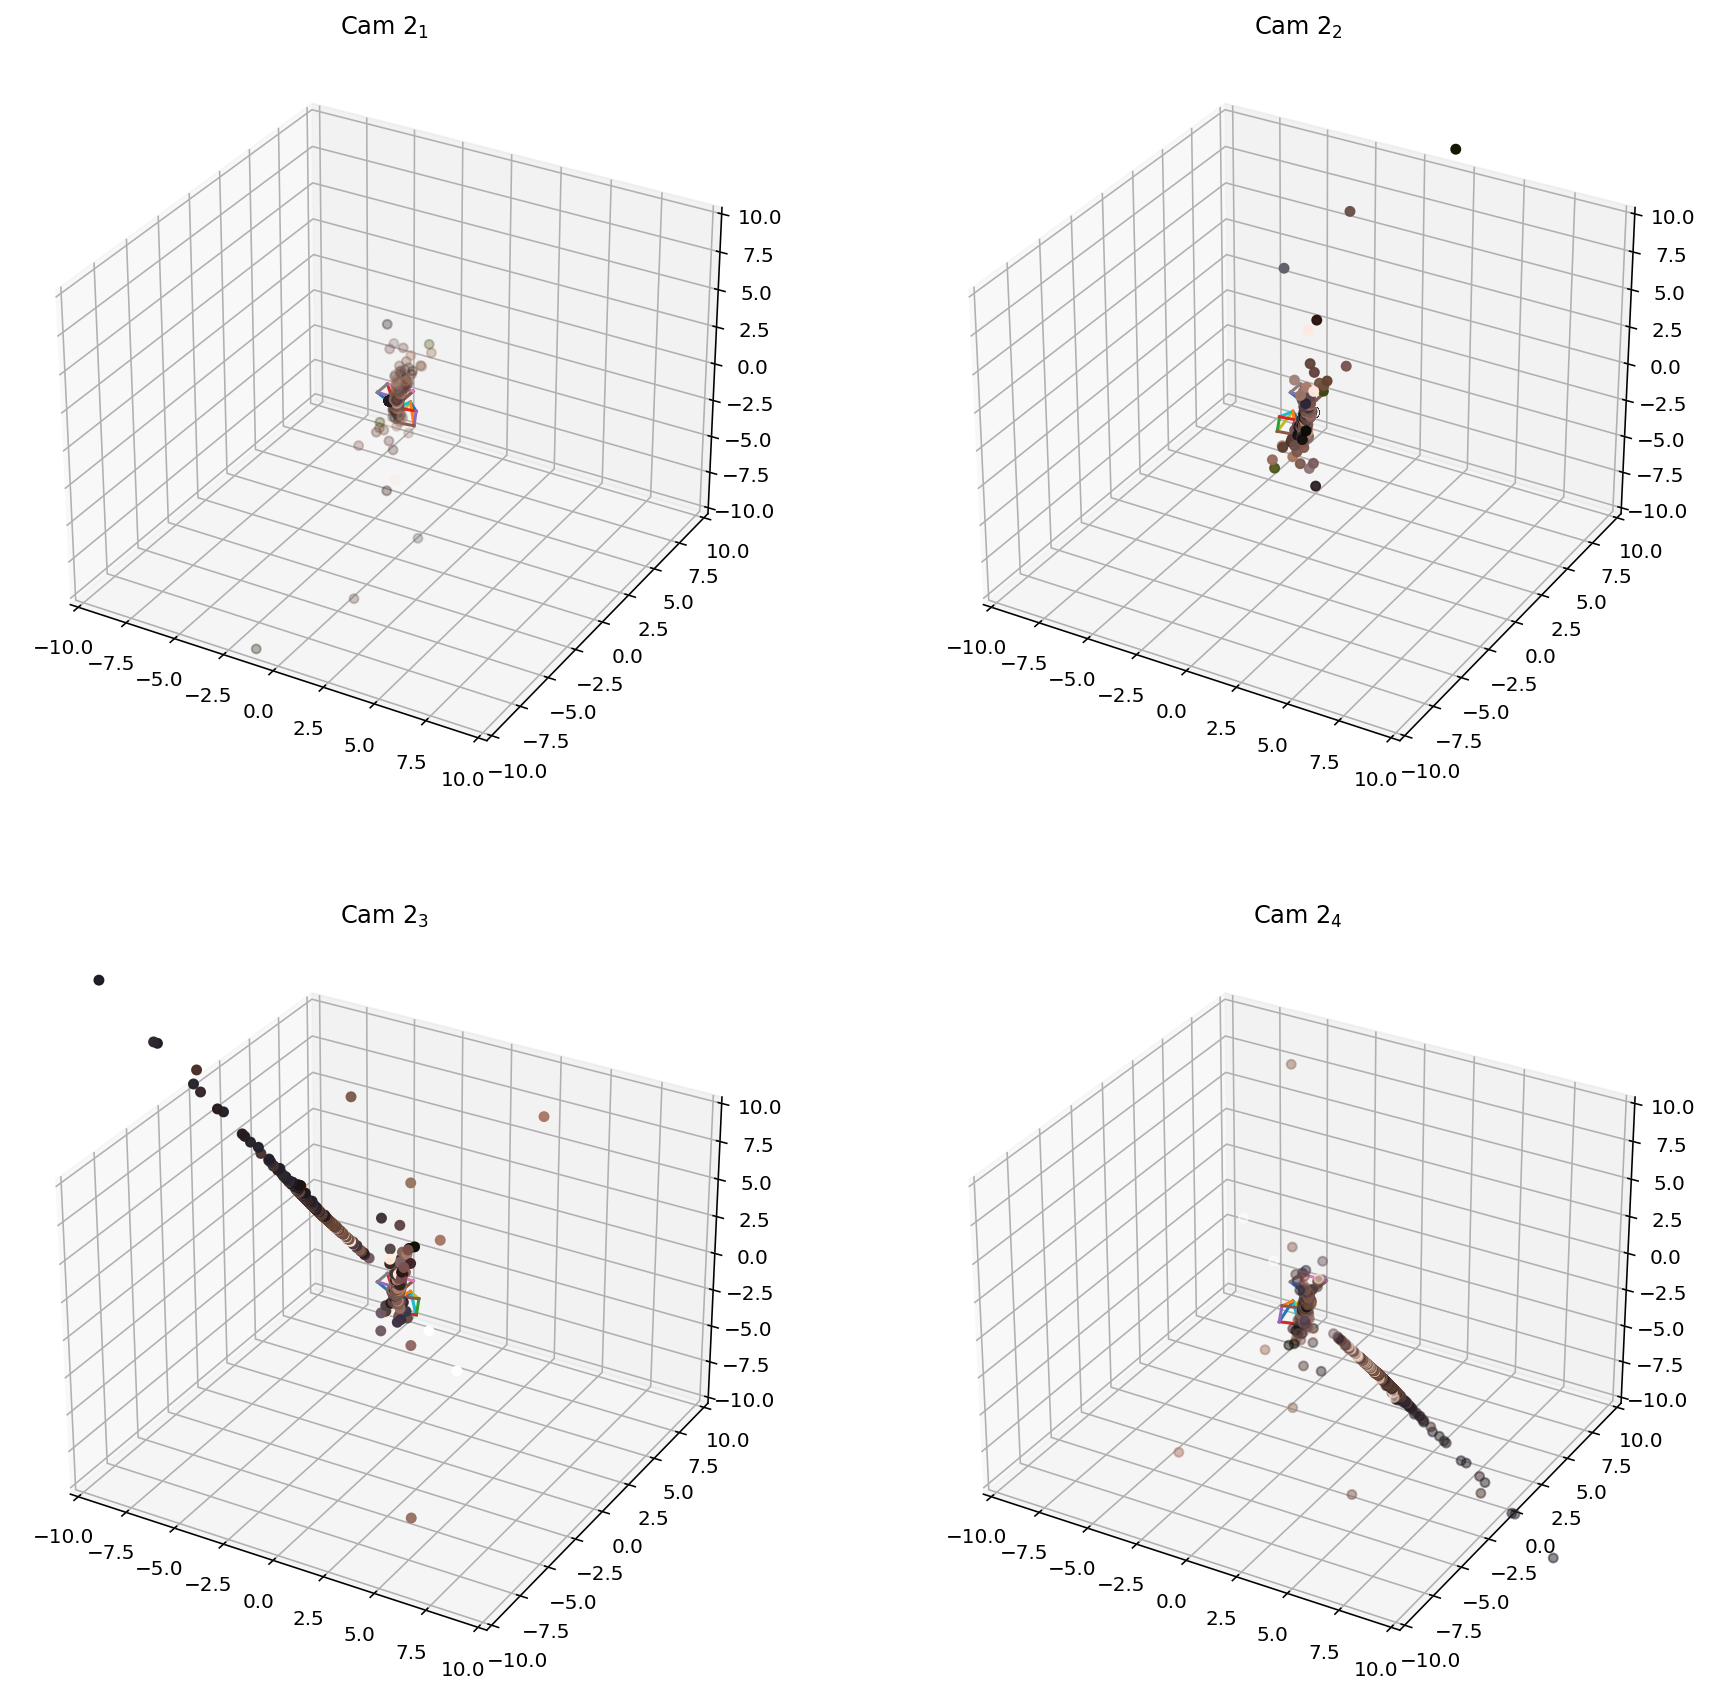

In [112]:
img1 = cv2.imread('Data_W3/0001_s.png',cv2.IMREAD_UNCHANGED)


# Obtain the inlier points projective coordinates for Camera 1 and 2 
x1 = points1
x2 = points2

# Prepare figure 
fig = plt.figure(figsize=(15,15))
axs = [fig.add_subplot(2,2,i+1, projection='3d') for i in range(4)]

# Variable for optimal camera
P2_selected = None

low_lim, up_lim = -10, 10

max_metric=0
for i, ax, P2 in zip(range(len(Pc2)), axs, Pc2):
    # Estimate by triangulization the 3D coordinates of the matches
    X_pred = triangulate(x1, x2, P1, P2, [w, h])
    X_eucl = homogeneous2euclidean(X_pred)
    X_pred = X_pred / X_pred[3][np.newaxis]
    
    # Render the 3D point cloud
    x_img = np.transpose(x1[:2]).astype(int)
    rgb_txt = (img1[x_img[:,1], x_img[:,0]])/255
    utils.draw_points(X_eucl.T, color=rgb_txt, ax=ax)
    utils.plot_camera(P1,w,h,1, ax=ax)
    utils.plot_camera(P2,w,h,1, ax=ax)
    ax.set_title(r"Cam $2_{%d}$" % (i+1))
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.set_zlim(low_lim, up_lim)

    # Select the best camera using some metric 
    x1_estimate = P1 @ X_pred
    x2_estimate = P2 @ X_pred
    
    # The depth must be higher than zero in both views
    some_metric=0
    for j in range(len(x1_estimate[2])):
        if x1_estimate[2,j]>0 and x2_estimate[2,j]>0:
            some_metric+=1
    print(some_metric)
    if some_metric>max_metric:
        P2_selected = P2
        max_metric=some_metric

# From now own P2 will be the camera you selected
P2 = P2_selected
print(P2)

## 2.7 Visualize the sparse reconstruction using the 2 images from lab 3, and the complete CASTLE dataset. Comment on the differences between techniques and number of images used. (1.0)
#### <span style='color:Green'> - Use the reconstruction from Colmap to the get the 3D points and visualize them following the same style, using two images and the complete dataset. </span>

In [30]:
### TO DO 2.7

: 